In [1]:
import sympy
import argparse

import equations
import data

import sympy

import sys
import os

import matplotlib.pyplot as plt

from derivative import dxdt
import sys
import os
directory_path = os.getcwd()
sys.path.append(directory_path + '/gplearn/')
from gplearn.genetic import SymbolicRegressor
from utils import generator
import numpy as np

import pickle

In [2]:
ode_name = 'GompertzODE'
noise_sigma = 0.09
n_sample = 50
freq = 10
x_id = 0
seed_s = 0
seed_e = 1

path_base = 'results/{}/noise-{}/sample-{}/freq-{}/'.format(ode_name, noise_sigma, n_sample, freq)
res_list = []
for s in range(seed_s, seed_e):
    if x_id == 0:
        path = path_base + 'grad_seed_{}.pkl'.format(s)
    else:
        path = path_base + 'grad_x_{}_seed_{}.pkl'.format(x_id, s)

    try:
        with open(path, 'rb') as f:
            res = pickle.load(f)
        res_list.append(res)
    except FileNotFoundError:
        pass
len(res_list)

1

In [3]:
path_base = 'results_vi/{}/noise-{}/sample-{}/freq-{}/'.format(ode_name, noise_sigma, n_sample, freq)
res_list_vi = []
for s in range(seed_s, seed_e):
    if x_id == 0:
        path = path_base + 'grad_seed_{}.pkl'.format(s)
    else:
        path = path_base + 'grad_x_{}_seed_{}.pkl'.format(x_id, s)

    try:
        with open(path, 'rb') as f:
            res = pickle.load(f)
        res_list_vi.append(res)
    except FileNotFoundError:
        pass
len(res_list_vi)

1

In [4]:
T, B, D = res_list[0]['dg'].xt.shape

In [5]:
b = 2

x_true = res_list[0]['dg'].xt[:, b, 0]
x_noise = res_list[0]['dg'].yt[:, b, 0]
x_hat = res_list_vi[0]['ode_data']['x_hat'][:, b, 0]
t = res_list[0]['dg'].solver.t

In [6]:
y_hat = res_list[0]['y_train'].reshape(T-1, B)[:, b]
y_hat_spline = dxdt(x_noise, t, kind="spline", s=0.012)[:-1]
y_hat_direct = dxdt(x_noise, t, kind="spline", s=0.005)[:-1]
y_true = res_list[0]['ode']._dx_dt(x_true)[0][:-1]

In [7]:
ode_name = 'GompertzODE'
noise_sigma = 0.02
n_sample = 50
freq = 2
x_id = 0
seed_s = 0
seed_e = 1

path_base = 'results/{}/noise-{}/sample-{}/freq-{}/'.format(ode_name, noise_sigma, n_sample, freq)
res_list2 = []
for s in range(seed_s, seed_e):
    if x_id == 0:
        path = path_base + 'grad_seed_{}.pkl'.format(s)
    else:
        path = path_base + 'grad_x_{}_seed_{}.pkl'.format(x_id, s)

    try:
        with open(path, 'rb') as f:
            res = pickle.load(f)
        res_list2.append(res)
    except FileNotFoundError:
        pass
len(res_list2)
path_base = 'results_vi/{}/noise-{}/sample-{}/freq-{}/'.format(ode_name, noise_sigma, n_sample, freq)
res_list2_vi = []
for s in range(seed_s, seed_e):
    if x_id == 0:
        path = path_base + 'grad_seed_{}.pkl'.format(s)
    else:
        path = path_base + 'grad_x_{}_seed_{}.pkl'.format(x_id, s)

    try:
        with open(path, 'rb') as f:
            res = pickle.load(f)
        res_list2_vi.append(res)
    except FileNotFoundError:
        pass
len(res_list2_vi)

1

In [8]:
T, B, D = res_list2[0]['dg'].xt.shape

b = 2

x_true2 = res_list2[0]['dg'].xt[:, b, 0]
x_noise2 = res_list2[0]['dg'].yt[:, b, 0]
x_hat2 = res_list2_vi[0]['ode_data']['x_hat'][:, b, 0]
t2 = res_list2[0]['dg'].solver.t

y_hat2 = res_list2[0]['y_train'].reshape(T-1, B)[:, b]
y_hat_spline2 = dxdt(x_noise2, t2, kind="spline", s=0.001)
y_hat_direct2 = dxdt(x_noise2, t2, kind="spline", s=0.00)
y_true2 = res_list2[0]['ode']._dx_dt(x_true2)[0][:-1]

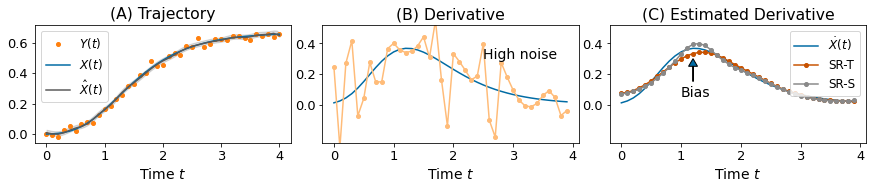

In [9]:
plt.figure(figsize=(12,2.5))
plt.style.use('tableau-colorblind10')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams['font.size'] = '13'

plt.subplot(131)
plt.fill_between(res_list_vi[0]['t_new'], x_hat-0.01, x_hat+0.02, alpha=0.2, color=colors[3])
plt.plot(t, x_noise, 'o', ms=4, label=r'$Y(t)$', color=colors[1])
plt.plot(t, x_true, label=r'$X(t)$', color=colors[0])
plt.plot(res_list_vi[0]['t_new'][::2], x_hat[::2], '-', ms=4, label=r'$\hat{X}(t)$', color=colors[3])
# plt.ylabel('Trajectory', fontsize=14)
plt.xlabel(r'Time $t$', fontsize=14)
plt.title('(A) Trajectory')
plt.legend(fontsize=12)

plt.subplot(132)
plt.plot(t[:-1], y_true, label=r'$\dot{X}(t)$ True')
plt.plot(t[:-1], y_hat_direct, 'o-', ms=4, label=r'${\dot{X}}(t)$ TV', color=colors[8])
# plt.ylabel('Derivative', fontsize=14)
plt.yticks([0., 0.2, 0.4])
plt.xlabel(r'Time $t$', fontsize=14)
plt.ylim((-0.25, 0.52))
plt.text(s='High noise', x=2.5, y=0.3, color='black', fontsize=14)
plt.title('(B) Derivative')

plt.subplot(133)
plt.plot(t[:-1], y_true, label='${\dot{X}}(t)$')
plt.plot(t[:-1], y_hat, 'o-', ms=4, label=r'SR-T', color=colors[5])
plt.plot(t[:-1], y_hat_spline, 'o-', ms=4, label=r'SR-S', color=colors[6])
# plt.ylabel('Derivative', fontsize=14)
plt.yticks([0., 0.2, 0.4])
plt.xlabel(r'Time $t$', fontsize=14)
plt.ylim((-0.25, 0.52))
# plt.axvline(x=0, linestyle='--', color='black')
# plt.axvline(x=1.5, linestyle='--', color='black')
plt.text(s='Bias', x=1., y=0.05, color='black', fontsize=14)
plt.arrow(1.2, 0.15, 0., 0.15, head_length=0.05, head_width=0.15, length_includes_head=True)
plt.legend(fontsize=12)
plt.title('(C) Estimated Derivative')


plt.tight_layout(pad=0.2)

plt.savefig(fname='Gompertz_plot.png', dpi=200)